In [ ]:
#OK ( save the model )

In [ ]:
# https://www.datacourses.com/classification-model-evaluation-metrics-in-scikit-learn-924/


| |<font size="5">Classification  _  تصنيف البيانات </font>|
|-:|-:|
|<img src="https://www.tibco.com/blog/wp-content/uploads/2013/04/telco-churn.jpg" width=250></img>||
||<font size="4"> تحميل البيانات  </font>|
||<font size="4">  تحديد تسلسل معالجة البيانات</font>|
||<font size="4">XGBClassifier    تدريب البيانات وتقليص خصائصها </font>|
||<font size="4"> تقويم أداء الخوارزميات </font>|

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-03-16 17:22:28.941379: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 17:22:29.601983: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 17:22:30.191011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742145750.553189    9042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742145750.651291    9042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 17:22:31.497259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Num GPUs Available:  0


2025-03-16 17:22:38.106926: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
#      تحميل البيانات
import numpy as np
import pandas as pd

df = pd.read_csv('../data/churn/churn_2.csv', index_col=0)

In [6]:
df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
#      تحميل البيانات
# تحديد الخصائص والهدف
X=df.drop("Churn", axis=1)
y=df["Churn"]

KeyError: "['Churn'] not found in axis"

In [ ]:
X.shape

(3333, 15)

In [ ]:
# تقسيم البيانات :  تدريب &  اختبار
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y  ,test_size=.33, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import make_column_transformer , make_column_selector  as selector
# from sklearn.compose import

from sklearn.pipeline import make_pipeline


num_pipeline= make_pipeline(
     StandardScaler()    # تغيير سلم البيانات الرقمية
)

cat_pipeline= make_pipeline(
     OneHotEncoder(drop="if_binary", sparse=False)  #   بما ان جميع القيم الناقصة قد تم تعويضا فلا فائدة من معالجتها لذا نقوم هنا باسقاط احد العمودين في حالة المتغير الثنائي

)

preprocess= make_column_transformer(
     ( num_pipeline,  selector(dtype_include="number") ),  #توظيف  سلسة معالجة الباينات أعلاه على جميع البيانات الرقمية
     (cat_pipeline, selector(dtype_exclude="number")) , #category  كان بالامكان تغيير  نوع المتغيرات الى تصنيف
     remainder="passthrough"  # واسقاط باقي البيانات الغير رقمية
     )

In [ ]:
# حجم البيانات الجديد
preprocess.fit_transform(X_train).shape

(2233, 65)

In [ ]:
# التحقق من تحويل  البيانات
preprocess.fit_transform(X_train)

array([[-0.81498972, -0.51621471, -0.588063  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76425984, -0.51621471,  1.16095039, ...,  0.        ,
         0.        ,  1.        ],
       [-0.33870811,  1.7389225 ,  2.25408377, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86512463, -0.68238272, -0.588063  , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.71682307, -0.51621471, -0.588063  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.61714823, -0.68238272,  2.545586  , ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
pipe_XGBCl= make_pipeline(
    preprocess,    # تغيير سلم البيانات الرقمية

    XGBClassifier()
)

In [ ]:
#pipeline  معايير
list(pipe_XGBCl.get_params().keys())

['memory',
 'steps',
 'verbose',
 'columntransformer',
 'xgbclassifier',
 'columntransformer__n_jobs',
 'columntransformer__remainder',
 'columntransformer__sparse_threshold',
 'columntransformer__transformer_weights',
 'columntransformer__transformers',
 'columntransformer__verbose',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-1__standardscaler',
 'columntransformer__pipeline-1__standardscaler__copy',
 'columntransformer__pipeline-1__standardscaler__with_mean',
 'columntransformer__pipeline-1__standardscaler__with_std',
 'columntransformer__pipeline-2__memory',
 'columntransformer__pipeline-2__steps',
 'columntransformer__pipeline-2__verbose',
 'columntransformer__pipeline-2__onehotencoder',
 'columntransformer__pipeline-2__onehotencoder__categories',
 'columntransformer__pipeline-2__onehotencoder__drop',
 '

In [ ]:
from sklearn import set_config
set_config(display='diagram', )

In [ ]:
param_grid = {
   'xgbclassifier__n_estimators': [150, 200],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgbclassifier__max_depth': range(3, 5),
    'xgbclassifier__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'xgbclassifier__gamma': [i/10.0 for i in range(3)],
    'xgbclassifier__scale_pos_weight': [1, 10, 25, 50],
  }

- Generally, scale_pos_weight is the ratio of number of negative class to the positive class.

Suppose, the dataset has 90 observations of negative class and 10 observations of positive class, then ideal value of scale_pos_weight should be 9.

In [ ]:
# Define cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score ),
    'roc_auc': make_scorer(roc_auc_score)
    }

### RandomizedSearchCV

![](https://adventuresindatascience.files.wordpress.com/2017/10/bb_rcv.png)

In [ ]:
# %%timeit
from sklearn.model_selection import RandomizedSearchCV
RdSearch = RandomizedSearchCV(pipe_XGBCl, param_distributions=param_grid, cv=kf, verbose=3,
                                n_jobs=-1 ,scoring= scorers   , n_iter=1000 , refit="roc_auc" )

In [ ]:
# التدريب
RdSearch.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 384 is smaller than n_iter=1000. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  6.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array 

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c4d956a50>),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps...
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.1,
                                                                         0.2,
                                                                         0.3],
                                        'xgbclassifier__max_depth': range(3, 5),
                                        'xgbclassifier__n_estimators': [150,
                                                                        200],
                                        'xgbclassifier__scale_pos_weight': [1,
                                                                            10,
                                                                            25,
                                                                            50]},
                   refit='roc_auc',
                   scoring={'accuracy_score': make_scorer(accuracy_score),
                            'precision_score': make_scorer(precision_score),
                            'recall_score': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)},
                   verbose=3)

In [ ]:
# افضل المعايير التي تم الاحتفاظ بها
RdSearch.best_params_

{'xgbclassifier__colsample_bytree': 0.2,
 'xgbclassifier__gamma': 0.0,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 150,
 'xgbclassifier__scale_pos_weight': 10}

In [ ]:
#  قائمة أفضل المعاييير
RdSearch.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c38d76610>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c38d769d0>)])),
                ('xgbclassifier',
                 XGBClassifier(colsample_bytree=0.2, gamma=0.0,
                               learning_rate=0.2, n_estimators=150,
                               scale_pos_weight=10))])

In [ ]:
# قياس الدقة في ضوء أفضل المعايير
f" Score {RdSearch.best_estimator_.score(X_test, y_test):.3}"

' Score 0.898'

In [ ]:
y_pred=RdSearch.predict(X_test)
f'Accuracy: {accuracy_score(y_test, y_pred):.3}'

'Accuracy: 0.898'

- Recall
Recall goes another route. Instead of looking at the number of false positives the model predicted, recall looks at the number of false negatives that were thrown into the prediction mix.
$$ Recall = \frac{TP}{TP + FN}$$

![](https://newbiettn.github.io/images/confusion-matrix-noted.jpg)


In [ ]:
# نسبة التنبؤ  بالمقارنة مع القيم الأصلية
f'Accuracy: {recall_score(y_test, y_pred):.3}'

'Accuracy: 0.838'

In [ ]:
#  Precision / recall  بين    F1  يوازن معيار القيس
from sklearn import metrics
f'Accuracy: {metrics.f1_score(y_test, y_pred):.3}'

'Accuracy: 0.705'

In [ ]:
#
f"Performance sur le train : {roc_auc_score(y_train, RdSearch.predict(X_train))} "

'Performance sur le train : 0.9632478563208143 '

In [ ]:
# overfitting problem
f"Performance sur le train : {roc_auc_score(y_test, RdSearch.predict(X_test)):0.3} "

'Performance sur le train : 0.873 '

In [ ]:
f"Performance sur le Test : {recall_score(y_test, RdSearch.predict(X_test)):0.3} "

'Performance sur le Test : 0.838 '

In [ ]:
! pip install  scikit-plot

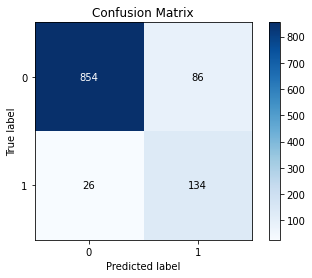

In [ ]:
#  Confusion Matrix
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred ) #, normalize=True)

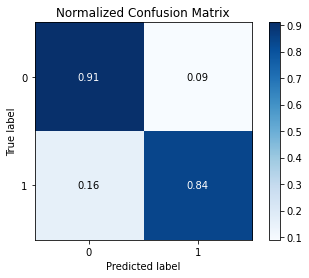

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred , normalize=True)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       940
           1       0.61      0.84      0.71       160

    accuracy                           0.90      1100
   macro avg       0.79      0.87      0.82      1100
weighted avg       0.92      0.90      0.90      1100



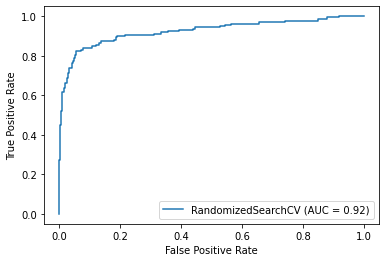

In [ ]:
metrics.plot_roc_curve(RdSearch, X_test, y_test)

In [ ]:
#AUC    قياس درجة  دقة  التنبؤ لمعيار
f'Best AUC Score: {RdSearch.best_score_ :.3}'


'Best AUC Score: 0.842'

In [ ]:
# جدول الأحتمالات
y_probas = RdSearch.predict_proba(X_test)

In [ ]:
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
y_probas

array([[0.37291723, 0.62708277],
       [0.98056823, 0.01943175],
       [0.07245415, 0.92754585],
       ...,
       [0.8970067 , 0.10299329],
       [0.08820617, 0.9117938 ],
       [0.5000855 , 0.49991453]], dtype=float32)

In [ ]:
((y_probas>0.5)+0)

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [ ]:
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
#  اشتقاق جدول التنبؤات
((y_probas>0.5)+0)[:,1]

array([1, 0, 1, ..., 0, 1, 0])

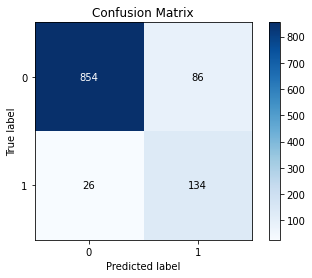

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, ((y_probas>0.5)+0)[:,1] ) #, normalize=True)

-  اسوء نتيجة هي تلك التي تنبأ بها النموذج على أن العميل لن يقطع عقده مع شركة الاتصالات ولكنه  على عكس المتوقع قطعه.
- لذا فإن الشكرة مستعدة لتفعيل حزمة من التدابير مثا تمتيع العميل بترقية للخدمات حتى تبقي عليه .

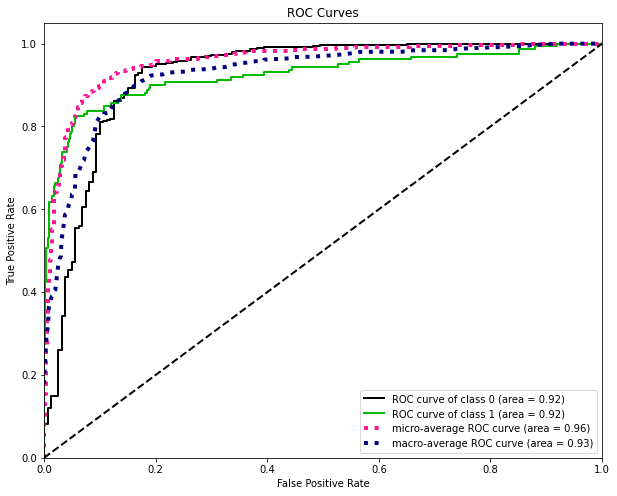

In [ ]:
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))

![](https://www.researchgate.net/profile/Md_Ashraful_Amin/publication/220176738/figure/fig4/AS:669969142534168@1536744499664/The-confusion-matrix-left-and-the-calculation-of-true-positive-rate-false-positive.png)

- The ROC in the figure has a high AUC. We can also see there’s a point on the graph where TPR(sensitivity) is quite high and FPR(1-specificity) is dramatically low. If we go back and look at our business need, we needed a high TPR and low FPR that is exactly what we are getting from that point on this ROC. The threshold corresponding to that point can be said to be the best threshold value.
https://towardsdatascience.com/demystifying-confusion-matrix-29f3037b0cfa

- F1-Score
In practice, when we try to increase the precision of our model, the recall goes down, and vice-versa. The F1-score captures both the trends in a single value:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


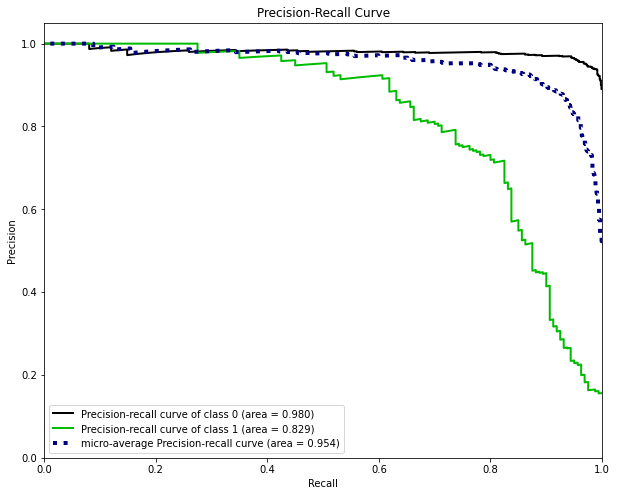

In [ ]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, figsize=(10, 8))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


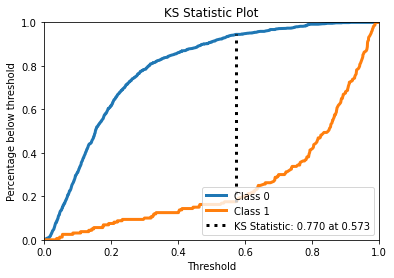

In [ ]:
# AUC تخطيط
# The K-S statistic plot, or the Kolmogorov Smirnov statistic plot, is a plot that tells you whether the model gets confused
#when it comes to predicting the different labels in your dataset

skplt.metrics.plot_ks_statistic(y_test, y_probas)

![](https://newbiettn.github.io/images/confusion-matrix-noted.jpg)

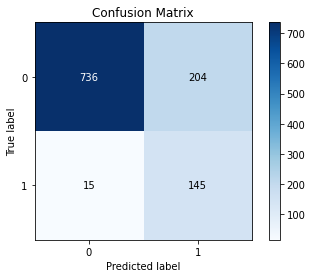

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, ((y_probas>0.3)+0)[:,1] ) #, normalize=True)

In [ ]:
# pickel

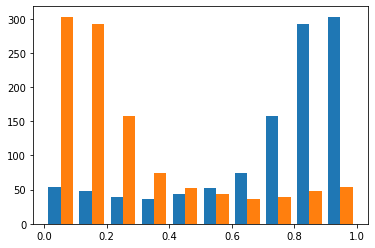

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_probas )

plt.show()

- Now coming to the business part, the Telecom company efficiently is balancing between reducing Churners (increasing TPR) and reducing wrong classification of good customers as probable Churners (lowering FPR).
- Therefore the organisation in this case can’t just rely on the **Accuracy** of the model.   

In [ ]:
metrics.confusion_matrix(y_test, ((y_probas>0.3)+0)[:,1])

array([[736, 204],
       [ 15, 145]])

- Finding the optimal cutoff¶
It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

قيمة الخسائر التي ستنمى بها شركة الاتصالات   في حالة مغادرة حرفائها

Cost  = $500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
FN(C) means that the fal

In [27]:
import numpy as np
A=np.array([[[736, 204], [15, 145]]])
B=np.array([[0, 100], [500, 100]])

A

array([[[736, 204],
        [ 15, 145]]])

In [25]:
np.array([[0, 100], [500, 100]])

array([[  0, 100],
       [500, 100]])

In [28]:
500*15+100*204+100*145

42400

In [29]:
np.sum(A*B)

42400

In [17]:
np.sum(np.matmul(A, B ) )

284500

In [ ]:
5+21

In [12]:
np.sum(np.array([[0, 100], [500, 100]]) )

700

In [ ]:
np.array([[0, 100], [500, 100]])

array([[  0, 100],
       [500, 100]])

- Matrix Multiplication
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Matrix_multiplication_diagram_2.svg/313px-Matrix_multiplication_diagram_2.svg.png)

In [ ]:
 np.array([[0, 100], [500, 100]])*metrics.confusion_matrix(y_test, ((y_probas>0.3)+0)[:,1])

array([[    0, 16700],
       [ 7500, 14500]])

In [ ]:
#
np.sum(np.array([[0, 100], [500, 100]]) *
                               metrics.confusion_matrix(y_test, ((y_probas>0.3)+0)[:,1])
                               )

42400

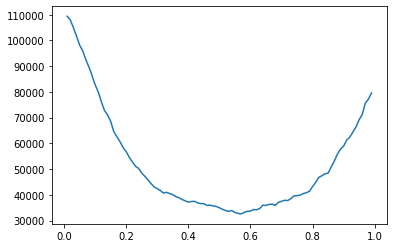

Cost is minimized near a cutoff of: 0.5700000000000001 for a cost of: 32600


In [ ]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(
        np.sum(np.array([[0, 100], [500, 100]]) *
                               metrics.confusion_matrix(y_test, ((y_probas>c)+0)[:,1])
                               )
        )


costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

-   0.5  يتضح لنا أن افضل معيار لتحديد جدول التنبؤات والذي يقلل من تلكفة  خسار شركة الاتصالات من خلال مغادرة العملاء هو

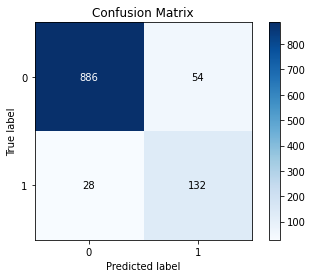

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, ((y_probas>0.57)+0)[:,1])